In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score, classification_report, f1_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [2]:
!pip install category_encoders

In [3]:
import category_encoders as ce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

In [5]:
hotel = pd.read_csv('hotel_bookings.csv')

# 1. Problem Framing

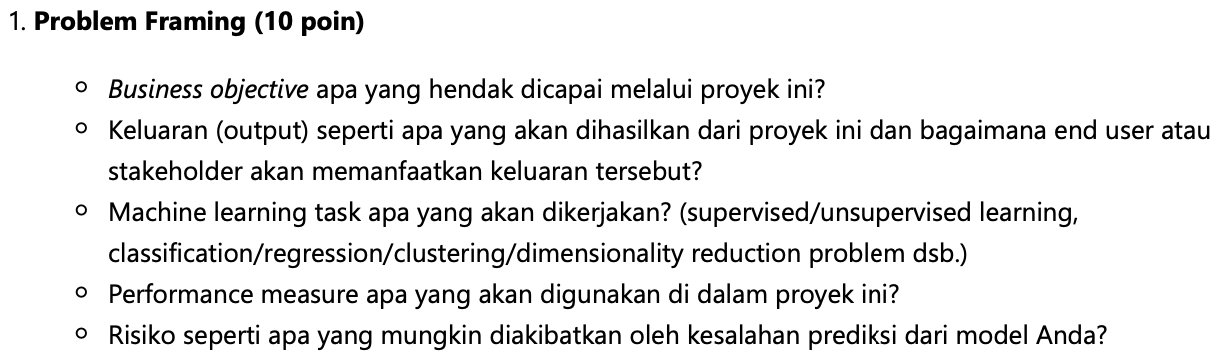

- Memprediksi apakah seseorang pelanggan yang telah memesan kamar hotel akan membatalkan pesananannya sehingga sebuah hotel dapat mengidentifikasi pembatalan pesanan lebih cepat untuk mengurangi resiko kerugian akibat pembatalan tersebut
- Sebuah model machine learning yang dapat memprediksi apakah pelanggan akan membatalkan pesananannya sehingga sebuah hotel dapat mengidentifikasi pembatalan pesanan lebih cepat
- Machine learning yang sesuai untuk problem ini adalah supervised learning dengan target is_canceled (1 cancel, 0 tidak) dengan metode classification
- Metrics yang lebih tepat untuk digunakan adalah f1 score karena meningkatkan recall dan precision sama pentingnya. Precision untuk meminimumkan False Positive (prediksi cancel, actual tidak) untuk menghindari terjadinya double booked karena mengasumsikan pelanggan akan cancel, sehingga memberikan kamar ke orang lain yang menyebabkan kehilangan kepercayaan oleh pelanggan. Sedangkan Recall untuk meminimumkan False Negative (prediksi tidak, actual cancel) yang merupakan tujuan utama untuk mengurangi resiko kerugian.
- Resiko ketika terjadi False Positive adalah double booked karena mengasumsikan pelanggan akan cancel, sehingga memberikan kamar ke orang lain yang menyebabkan kehilangan kepercayaan oleh pelanggan. Sedangkan False Negative dapat menyebabkan kerugian akibat pembatalan pesanan dari kamar yang tidak jadi digunakan.

# 2. Exploratory Data Analysis

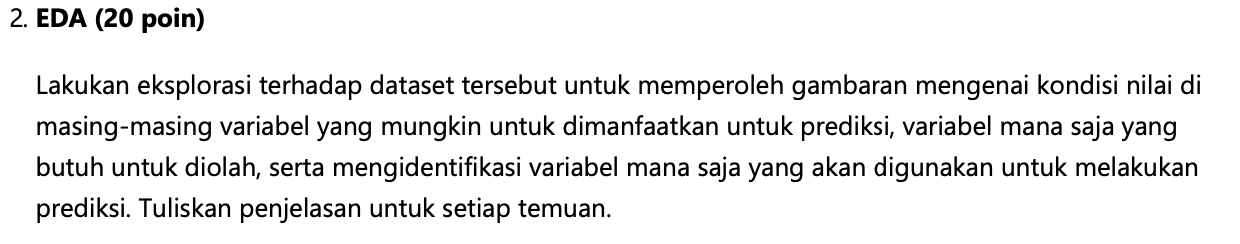

In [6]:
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [7]:
hotel.shape

(119390, 32)

In [8]:
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


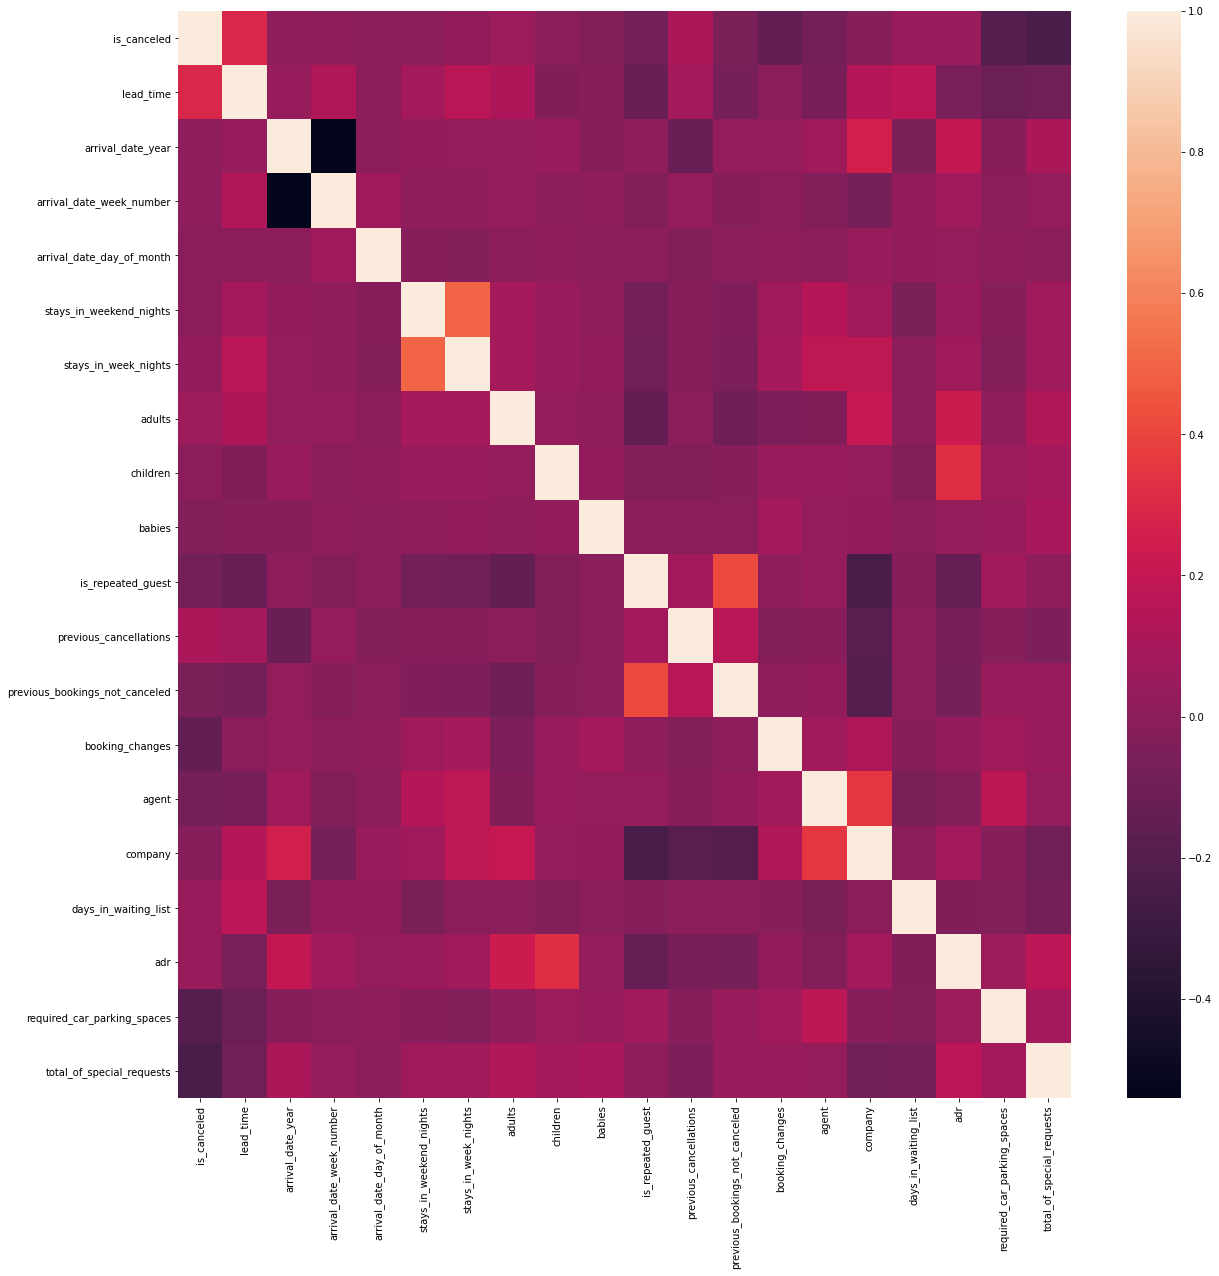

In [9]:
plt.figure(figsize=(20,20))
sns.heatmap(hotel.corr())

Beberapa feature menunjukkan adanya multicollinearity, yang akan coba dihilangkan di data preparation

Cancellation Situation

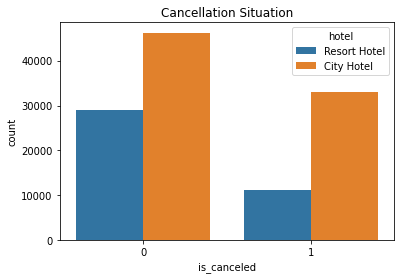

In [10]:
sns.countplot(x='is_canceled', hue = 'hotel', data= hotel)
plt.title('Cancellation Situation')
plt.show()

City hotel lebih banyak dibooking dan dilakukan pembatalan

Country of Origin

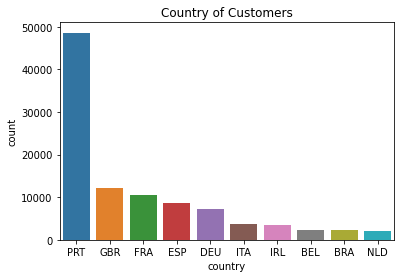

In [11]:
country_booking = hotel['country'].value_counts().rename_axis('country').reset_index(name='count')
sns.barplot(x='country', y='count', data=country_booking.head(10))
plt.title('Country of Customers')
plt.show()

Pelanggan terbanyak berasal dari Portugal

Customer Profiling

In [12]:
hotel['child'] = hotel['children'] + hotel['babies']
pd.crosstab(hotel['adults'], hotel['child'], margins=True, margins_name = 'Total')

child,0.0,1.0,2.0,3.0,9.0,10.0,Total
adults,,,,,,,
0,180,4,205,14,0,0,403
1,22577,286,157,6,1,0,23027
2,81557,4658,3369,91,0,2,89677
3,5665,495,41,0,0,0,6201
4,59,3,0,0,0,0,62
5,2,0,0,0,0,0,2
6,1,0,0,0,0,0,1
10,1,0,0,0,0,0,1
20,2,0,0,0,0,0,2


Berdasarkan data diatas dapat dilihat bahwa mayoritas pelanggan merupakan orang dewasa yang tidak membawa anak ataupun bayi sebesar 110054. Sebanyak 22577 orang dewasa booking untuk sendiri yang kemungkinan sedang dalam urusan bisnis. Pelanggan paling banyak terdapat pada kelompok orang dewasa yang berdua sebesar 81557 yang kemungkinan merupakan pasangan yang liburan.

Room Type

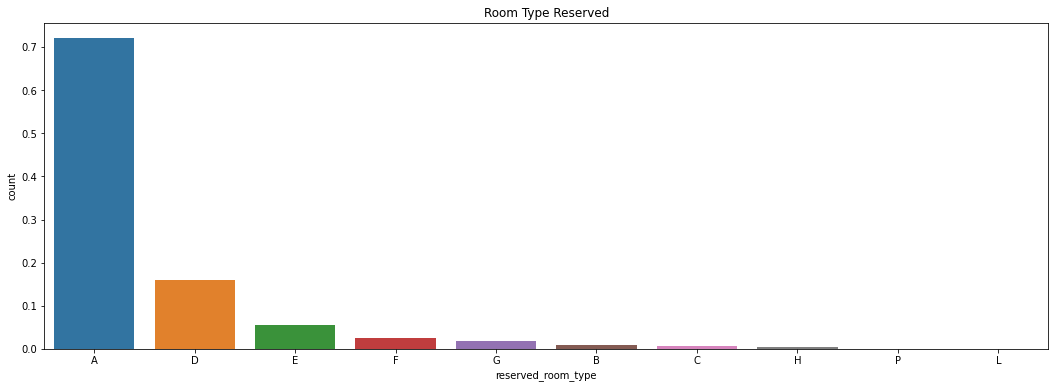

In [13]:
plt.figure(figsize=(18,6))
room = hotel['reserved_room_type'].value_counts(normalize=True).rename_axis('reserved_room_type').reset_index(name='count')
sns.barplot(x='reserved_room_type', y='count', data= room)
plt.title('Room Type Reserved')
plt.show()

Mayoritas pelanggan melakukan booking untuk kamar tipe A

Market Segmentation

No handles with labels found to put in legend.


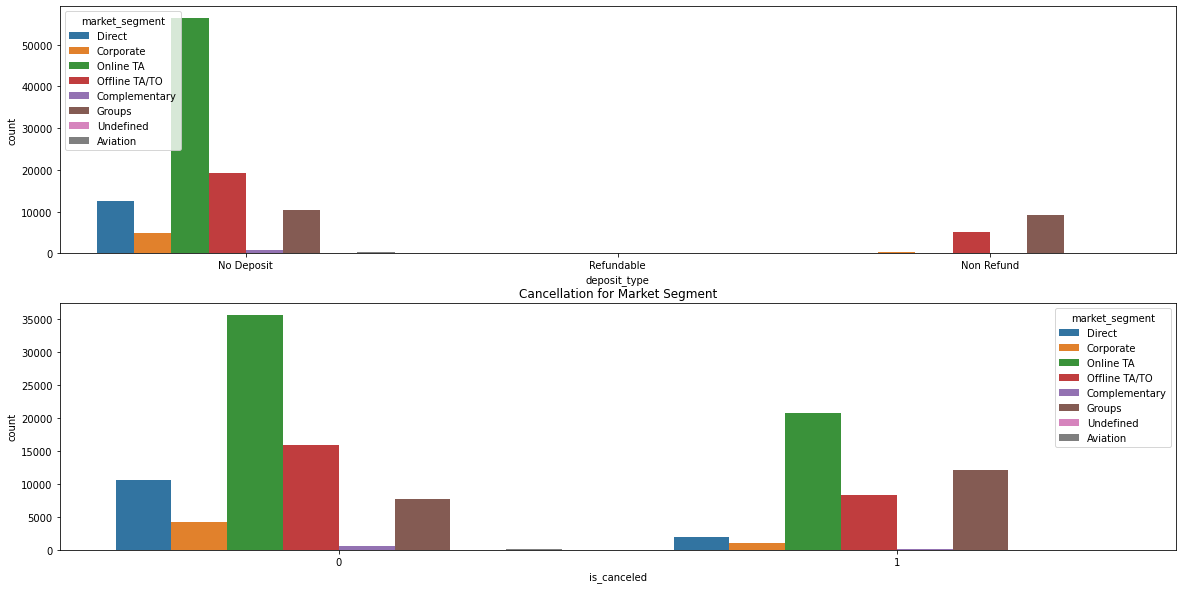

In [14]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
sns.countplot(ax=ax[0], data=hotel,x='deposit_type',hue='market_segment')
plt.title('Deposit Type for Market Segment')
plt.legend(loc = 1)
sns.countplot(ax=ax[1],data=hotel,x='is_canceled',hue='market_segment')
plt.title('Cancellation for Market Segment')
plt.show()

Booking terbanyak dilakukan melalui online TA dengan no deposit, begitu pula dengan cancellationnya. Selain itu, yang perlu diperhatikan adalah groups, meskipun jumlah bookingnya sedikit, namun cancellationnya cukup besar.

In [15]:
#create function for distribution plot
def dist_plot(df, var, bin) :
    plt.style.use('seaborn')
    fig, (ax1,ax2) = plt.subplots(2,figsize=(8,6), sharex=True)
    fig.suptitle(var +' Distribution', size=15,fontweight='bold')

    #calculate mean, median, mode
    mean = df[var].mean()
    med = df[var].median()
    mode = df[var].mode()[0]

    #create boxplot
    sns.boxplot(x=df[var], ax=ax1)
    ax1.set_xlabel('')

    #create histogram
    sns.histplot(x=df[var], bins=bin, kde=True, ax=ax2)   
    ax2.set_xlabel(var)
    ax2.set_ylabel('Frequency')
     #add vertical line histogram
    ax2.axvline(mean, color = 'b', linestyle='dashed',label='Mean :'+str(round(mean,2)))
    ax2.axvline(med, color = 'k', linestyle='dashdot',label='Median :'+str(round(med,2)))
    ax2.axvline(mode, color = 'c', linestyle='dotted',label='Mode :'+str(round(mode,2)))
    ax2.legend(loc='upper right')
    
    plt.show()

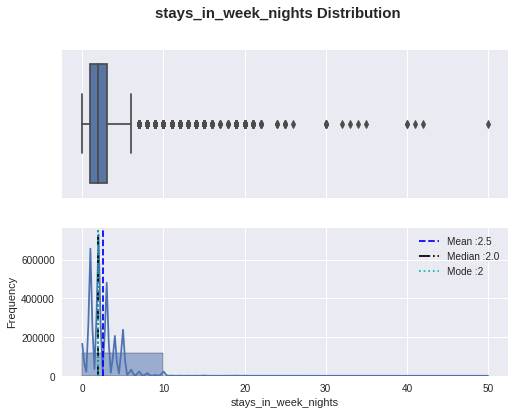

In [16]:
dist_plot(hotel, 'stays_in_week_nights',5)

Jumlah bermalam pada hari Senin-Jumat menunjukkan distibusi yang left skewed. 0 mengindikasikan pelanggan menginap saat weekend. Dan jumlah diatas 5 hari berarti pelanggan menginap lebih dari 1 minggu.

# 3. Data Preparation

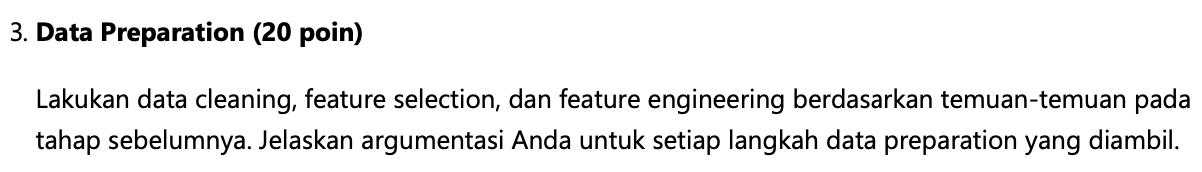

Checking & Filling NA values

In [17]:
hotel.isna().sum()/len(hotel)

hotel                             0.000000
is_canceled                       0.000000
lead_time                         0.000000
arrival_date_year                 0.000000
arrival_date_month                0.000000
arrival_date_week_number          0.000000
arrival_date_day_of_month         0.000000
stays_in_weekend_nights           0.000000
stays_in_week_nights              0.000000
adults                            0.000000
children                          0.000034
babies                            0.000000
meal                              0.000000
country                           0.004087
market_segment                    0.000000
distribution_channel              0.000000
is_repeated_guest                 0.000000
previous_cancellations            0.000000
previous_bookings_not_canceled    0.000000
reserved_room_type                0.000000
assigned_room_type                0.000000
booking_changes                   0.000000
deposit_type                      0.000000
agent      

- Ada 4 feature yang memiliki NA values, yg mana agent dan company memiliki data NA yg cukup signifikan. Oleh karena itu, dua fitur ini akan di drop mengingat informasi yang diberikan juga sedikit dan dua feature ini pada kenyataannya tidak berpengaruh karena keputusan pembatalan pesanan berada di pelanggan.
- Dua feature lainnya, yakni children dan country akan di impute dengan 0 dan others

In [18]:
hotel.drop(['agent','company'],axis=1,inplace=True) #dropping agent and company

In [19]:
hotel['children'].fillna(0,inplace=True) #filling NA values of children with 0 (No children)

In [20]:
hotel['country'].fillna('Others',inplace=True) #filling NA values of country with other

In [21]:
hotel.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

Feature Selection

In [22]:
hotel.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'child'],
      dtype='object')

- Beberapa feature merepresentasikan hal yg sejenis dengan feature lainnya, seperti arrival_date_month, arrival_date_week_number, dst. Oleh karena itu akan dipilih hanya 1 dari yang sejenis
- Selain itu, beberapa feature tidak merepresentasikan hubungan dengan pembatalan, seperti room_type, required_car_parking_spaces, dst karena diasumsikan customer sudah mengetahui hal-hal tersebut pada saat melakukan booking sehingga tidak akan berpengaruh terhadap pembatalan. Dan juga, feature seperti adr tidak mempengaruhi keputusan pelanggan untuk membatalkan, mengingat hal tersebut merupakan revenue per room dari hotel
-Berdasarkan asumsi diatas, maka feature yang akan digunakan adalah hotel, arrival_date_month, stays_in_weekend, stays_in_weeknight, adults,children,babbies,country,market_segment,is_repeated_guest,previous_cancellation,deposit_type,customer_type dengan target is_canceled

In [23]:
hotel_select = hotel[['hotel','is_canceled','arrival_date_month','stays_in_week_nights','adults','children','babies','country','market_segment','is_repeated_guest','previous_cancellations','deposit_type','customer_type']].copy()

In [24]:
hotel_select.head()

,hotel,is_canceled,arrival_date_month,stays_in_week_nights,adults,children,babies,country,market_segment,is_repeated_guest,previous_cancellations,deposit_type,customer_type
0,Resort Hotel,0,July,0,2,0.0,0,PRT,Direct,0,0,No Deposit,Transient
1,Resort Hotel,0,July,0,2,0.0,0,PRT,Direct,0,0,No Deposit,Transient
2,Resort Hotel,0,July,1,1,0.0,0,GBR,Direct,0,0,No Deposit,Transient
3,Resort Hotel,0,July,1,1,0.0,0,GBR,Corporate,0,0,No Deposit,Transient
4,Resort Hotel,0,July,2,2,0.0,0,GBR,Online TA,0,0,No Deposit,Transient


Checking Distribution and MultiCollinearity

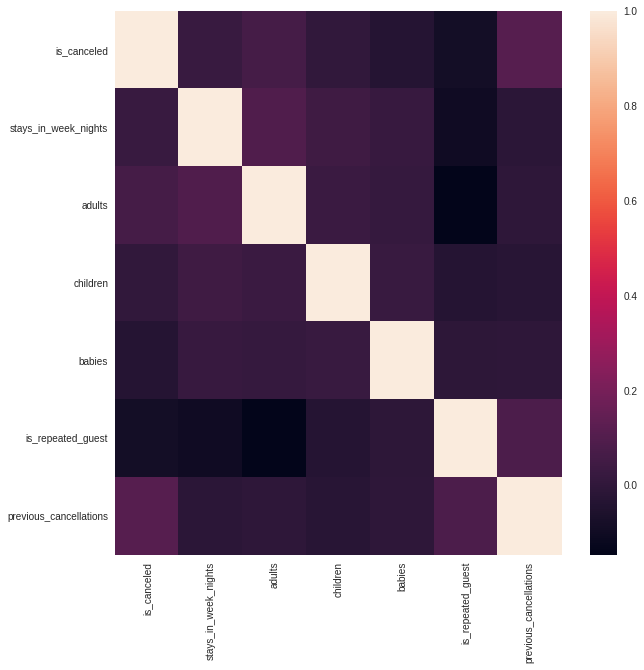

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(hotel_select.corr())

Berdasarkan figur diatas, tidak terlihat adanya multicollinearity

# 4. Model Training

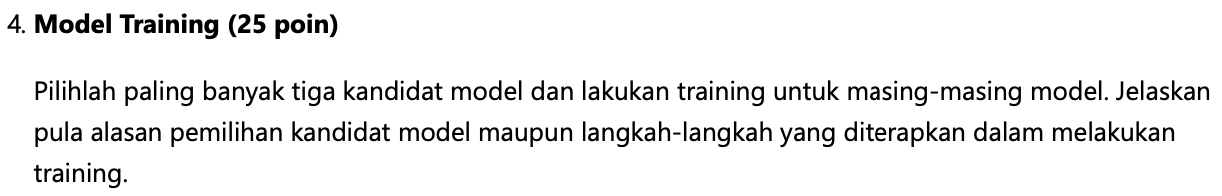

Train Test Split

In [26]:
#train test split with stratified y to avoid information leakage
X = hotel_select.drop('is_canceled', axis=1)
y = hotel_select['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2021)

In [27]:
X.head()

,hotel,arrival_date_month,stays_in_week_nights,adults,children,babies,country,market_segment,is_repeated_guest,previous_cancellations,deposit_type,customer_type
0,Resort Hotel,July,0,2,0.0,0,PRT,Direct,0,0,No Deposit,Transient
1,Resort Hotel,July,0,2,0.0,0,PRT,Direct,0,0,No Deposit,Transient
2,Resort Hotel,July,1,1,0.0,0,GBR,Direct,0,0,No Deposit,Transient
3,Resort Hotel,July,1,1,0.0,0,GBR,Corporate,0,0,No Deposit,Transient
4,Resort Hotel,July,2,2,0.0,0,GBR,Online TA,0,0,No Deposit,Transient


In [28]:
hotel_select.is_repeated_guest.value_counts()

0    115580
1      3810
Name: is_repeated_guest, dtype: int64

Data Preprocessing

In [29]:
!pip install --user --upgrade scikit-learn #untuk handle unknown

Requirement already up-to-date: scikit-learn in /root/.local/lib/python3.7/site-packages (0.24.2)


- Melalukan scaling dengan minmax karena data tidak berdistribusi normal
- Encoding dengan onehot, ordinal, dan binary

In [34]:
scaled = ['stays_in_week_nights', 'adults', 'children','babies','is_repeated_guest','previous_cancellations']
onehot_encoded = ['hotel', 'market_segment', 'deposit_type','customer_type']
ordinal_encoded = ['arrival_date_month']
binary_encoded = ['country']

col_transformer = make_column_transformer(
                        (MinMaxScaler(),scaled),
                        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan),ordinal_encoded),
                        (OneHotEncoder(handle_unknown='ignore',sparse=False),onehot_encoded),
                        (ce.BinaryEncoder(),binary_encoded)
                        )
X_train_prep = col_transformer.fit_transform(X_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


- Model Training dengan Random Search CV karena dataset besar sehingga Grid Search memakan waktu lama

- Model yang akan digunakan untuk classification :
  - Logistic Regression, standard model untuk classification
  - Random Forest, merupakan ensemble method (bagging)
  - Adaboost, juga merupakan ensemble method (boosting)

In [53]:
print('LR :',cross_val_score(LogisticRegression(solver='liblinear'),X_train_prep, y_train).mean())

LR : 0.7587857625235745


In [54]:
print('RF :',cross_val_score(RandomForestClassifier(),X_train_prep, y_train).mean())

RF : 0.7957354484487508


In [55]:
print('ADB :',cross_val_score(AdaBoostClassifier(),X_train_prep, y_train).mean())

ADB : 0.7654386157133662


5. Evaluation, Model Selection, and Tuning

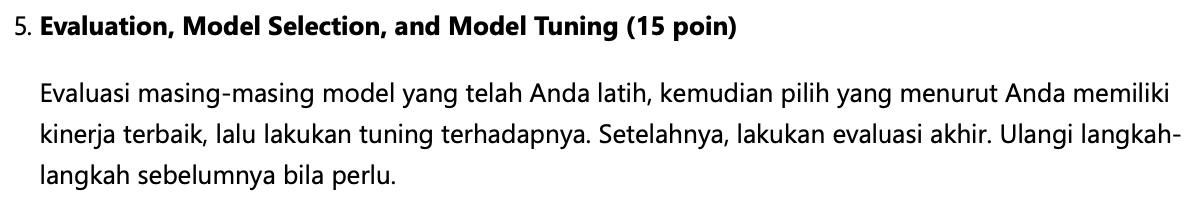

In [57]:
model_params = {
    'lr' : {
        'model': LogisticRegression(solver='liblinear'),
        'params' : {
            'C' : [1,10]
        }
    },
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'criterion' : ['gini','entropy'],
            'min_samples_split' : [2,4]
        }
    },
    'adaboost' : {
        'model' : AdaBoostClassifier(),
        'params' : {
            'learning_rate' : [0.1, 1]
        }
    }
}

In [58]:
f1 = []
for model_name, mp in model_params.items():
  grid = RandomizedSearchCV(estimator=mp['model'],param_distributions=mp['params'],cv=5, scoring='f1', n_jobs=-1)
  grid.fit(X_train_prep, y_train)

  f1.append({
      'model': model_name,
      'best_score': grid.best_score_,
      'best_params' : grid.best_params_
  })

/root/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/root/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/root/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [59]:
pd.DataFrame(f1)

,model,best_score,best_params
0,lr,0.597552,{'C': 10}
1,random_forest,0.703965,"{'min_samples_split': 4, 'criterion': 'gini'}"
2,adaboost,0.616021,{'learning_rate': 1}


F1 score terbaik didapatkan oleh RandomForest dengan min_samples_split 4 dan criterion gini

Build Best ML Estimator and Prediction

In [60]:
X_test_prep = col_transformer.transform(X_test) #preprocessing X_test

In [61]:
adb = RandomForestClassifier(min_samples_split=4, criterion='gini')
adb.fit(X_train_prep,y_train)
y_pred = adb.predict(X_test_prep)

In [62]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     22550
           1       0.77      0.64      0.70     13267

    accuracy                           0.80     35817
   macro avg       0.79      0.76      0.77     35817
weighted avg       0.79      0.80      0.79     35817



6. Result, Conclusion, and Recommendation

Berdasarkan hasil pengolahan data, hyperparameter tuning, dan pembuatan machine learning algorithm, didapatkan hasil yang terbaik dengan menggunakan Random Forest yang menghasilkan F1 Scores sebesar 0.7. Cukup baik untuk memprediksi kemungkinan terjadinya pembatalan oleh pelanggan. Pihak hotel dapat menggunakan machine learning model ini untuk memprediksi hal tersebut. Apabila terprediksi suatu pelanggan akan membatalkan pesanan, pihak hotel dapat menganggap kamar yang di booking kosong dan menawarkan ke pelanggan lainnya sehingga resiko terjadinya kerugian dapat dikurangi. 